<a href="https://colab.research.google.com/github/buyablemos/BitcoinClassifier/blob/main/UNIFIED_Bitcoin_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy

In [1]:
!pip install torch torch-geometric kagglehub pandas scikit-learn -q

import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm, Parameter,  PReLU, Dropout
from torch_geometric.nn import SAGEConv, GATConv,GATv2Conv, GCNConv
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używam urządzenia: {device}")

Używam urządzenia: cuda


# Pobieranie i preprocessing

In [2]:
dataset_path = kagglehub.dataset_download("ellipticco/elliptic-data-set")
base_path = f"{dataset_path}/elliptic_bitcoin_dataset"

df_features = pd.read_csv(f"{base_path}/elliptic_txs_features.csv", header=None)
df_classes = pd.read_csv(f"{base_path}/elliptic_txs_classes.csv")
df_edges = pd.read_csv(f"{base_path}/elliptic_txs_edgelist.csv")

feature_names = ['txId', 'time'] + [f'local_{i}' for i in range(1, 94)] + [f'agg_{i}' for i in range(1, 73)]
df_features.columns = feature_names
df_full = df_features.merge(df_classes, on='txId', how='left')

class_map = {'unknown': -1, '2': 0, '1': 1}
df_full['label_idx'] = df_full['class'].map(class_map)

nodes = df_full['txId'].values
node_map = {id: i for i, id in enumerate(nodes)}
df_edges['txId1'] = df_edges['txId1'].map(node_map)
df_edges['txId2'] = df_edges['txId2'].map(node_map)
df_edges = df_edges.dropna().astype(int)
edge_index = torch.tensor(df_edges[['txId1', 'txId2']].values.T, dtype=torch.long).to(device)

Using Colab cache for faster access to the 'elliptic-data-set' dataset.


# Cechy i Skalowanie

In [3]:
feature_cols = [c for c in df_full.columns if c.startswith('local_')]
X = df_full[feature_cols].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

x = torch.tensor(X, dtype=torch.float).to(device)
y = torch.tensor(df_full['label_idx'].values, dtype=torch.long).to(device)
times = torch.tensor(df_full['time'].values, dtype=torch.long).to(device)

# Podział Train/Test (Split na kroku 39)


In [4]:
train_cutoff = 39
train_mask = (times <= train_cutoff) & (y != -1)
test_mask = (times > train_cutoff) & (y != -1)

# Wagi klas

In [5]:
y_train = y[train_mask]
count_0 = (y_train == 0).sum().float()
count_1 = (y_train == 1).sum().float()
weight_class_1 = count_0 / count_1
class_weights = torch.tensor([1.0, weight_class_1]).to(device)
loss_fn_cls = torch.nn.CrossEntropyLoss(weight=class_weights)

print(f"Train: {train_mask.sum().item()}, Test: {test_mask.sum().item()}")

Train: 35380, Test: 11184


# Augmentacja danych treningowych

In [6]:
train_idx = torch.where(train_mask)[0]
train_idx_0 = train_idx[(y[train_idx] == 0)]
train_idx_1 = train_idx[(y[train_idx] == 1)]

n0 = train_idx_0.numel()
n1 = train_idx_1.numel()

print(f"Przed augmentacją - Liczba 0 (Licit): {n0}, 1 (Illicit): {n1}")

# 1. Przygotowanie kontenerów na nowe dane
new_features_list = []
new_edges_list = []
new_times_list = []

multiplier = 2

# 2. Iterujemy po unikalnych krokach czasowych (zgodnie z Twoją logiką)
unique_ts = times[train_idx_1].unique()
current_max_node_idx = x.size(0)

print(f"Rozpoczynam augmentację z uwzględnieniem czasu ({len(unique_ts)} kroków)...")

for t in unique_ts:
    # Wybieramy węzły Illicit z danego kroku 't'
    mask_t = (times[train_idx_1] == t)
    nodes_in_t = train_idx_1[mask_t]

    n_t = nodes_in_t.numel()

    if n_t < 2:
        continue

    # Ile dodać?
    num_to_add = n_t * multiplier

    # Losujemy pary rodziców z tego samego czasu
    idx_local_a = torch.randint(0, n_t, (num_to_add,))
    idx_local_b = torch.randint(0, n_t, (num_to_add,))

    node_a = nodes_in_t[idx_local_a]
    node_b = nodes_in_t[idx_local_b]

    # --- Generowanie Cech (Mixup) ---
    lam = torch.rand((num_to_add, 1), device=x.device)
    noise = torch.randn((num_to_add, x.size(1)), device=x.device) * 0.01

    features_t = lam * x[node_a] + (1 - lam) * x[node_b] + noise
    new_features_list.append(features_t)

    # Nowe węzły dziedziczą czas 't'
    new_times_list.append(torch.full((num_to_add,), t, dtype=torch.long, device=x.device))

    # --- Generowanie Krawędzi (POPRAWIONE) ---
    new_indices_t = torch.arange(current_max_node_idx, current_max_node_idx + num_to_add, device=x.device)
    current_max_node_idx += num_to_add

    for i in range(num_to_add):
        parent_a = node_a[i]
        parent_b = node_b[i]
        new_node_idx = new_indices_t[i]

        # Pobieramy sąsiadów obu rodziców
        mask_a = (edge_index[0] == parent_a)
        mask_b = (edge_index[0] == parent_b)

        neighbors_a = edge_index[1][mask_a]
        neighbors_b = edge_index[1][mask_b]

        # Tworzymy pulę unikalnych kandydatów (suma zbiorów)
        pool = torch.cat([neighbors_a, neighbors_b]).unique()

        if pool.numel() > 0:
            # === KLUCZOWA ZMIANA ===
            # Zamiast brać wszystkich (sumę), celujemy w ŚREDNIĄ liczbę sąsiadów.
            # To sprawia, że nowy węzeł wygląda jak prawdziwy, a nie jak "hub".
            avg_degree = (neighbors_a.numel() + neighbors_b.numel()) // 2

            # Zabezpieczenie: bierzemy przynajmniej 1 sąsiada, ale nie więcej niż dostępnych w puli
            k = max(1, min(avg_degree, pool.numel()))

            # Losujemy k sąsiadów z puli (bez powtórzeń)
            # randperm daje losową kolejność indeksów
            perm = torch.randperm(pool.size(0))
            selected_neighbors = pool[perm[:k]]

            # Tworzymy krawędzie
            new_edges = torch.stack([
                torch.full_like(selected_neighbors, new_node_idx),
                selected_neighbors
            ], dim=0)
            new_edges_list.append(new_edges)

# 3. Sklejanie wszystkiego (Reszta bez zmian)
if len(new_features_list) > 0:
    x_aug_part = torch.cat(new_features_list, dim=0)
    times_aug_part = torch.cat(new_times_list, dim=0)

    x_augmented = torch.cat([x, x_aug_part], dim=0)
    y_aug_part = torch.ones(x_aug_part.size(0), dtype=torch.long, device=y.device)
    y_augmented = torch.cat([y, y_aug_part], dim=0)
    times_augmented = torch.cat([times, times_aug_part], dim=0)

    if len(new_edges_list) > 0:
        extra_edges = torch.cat(new_edges_list, dim=1)
        edge_index_augmented = torch.cat([edge_index, extra_edges], dim=1)
    else:
        edge_index_augmented = edge_index

    new_indices_global = torch.arange(x.size(0), x_augmented.size(0), device=y.device)
    train_idx_aug = torch.cat([train_idx, new_indices_global], dim=0)

    print(f"Dodano {x_aug_part.size(0)} nowych węzłów Illicit.")
    new_n1 = (y_augmented[train_idx_aug] == 1).sum().item()
else:
    print("Brak danych do augmentacji.")
    x_augmented, y_augmented, edge_index_augmented, train_idx_aug = x, y, edge_index, train_idx

Przed augmentacją - Liczba 0 (Licit): 31471, 1 (Illicit): 3909
Rozpoczynam augmentację z uwzględnieniem czasu (39 kroków)...
Dodano 7818 nowych węzłów Illicit.


# Wagi klas dla danych po augumentacji

In [7]:
weight_class_1_aug = n0 / new_n1
class_weights_aug = torch.tensor([1.0, weight_class_1_aug]).to(device)
loss_fn_cls_aug = torch.nn.CrossEntropyLoss(weight=class_weights_aug)

print(f"Liczba próbek klasy 1 po augumentacji: {new_n1}")
print(f"Nowa waga klasy 1 po augumentacji: {weight_class_1_aug:.4f}")

Liczba próbek klasy 1 po augumentacji: 11727
Nowa waga klasy 1 po augumentacji: 2.6836


# Definicje modeli

In [8]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()

        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)

        self.dropout = dropout

    def forward(self, x, edge_index=None):

        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.lin2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.lin3(x)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels)
        self.lin_skip1 = Linear(in_channels, hidden_channels)

        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)

        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_in = self.lin_skip1(x)
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x + x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x_in = x
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x + x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.conv3(x, edge_index)


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout, concat=True)
        self.lin_skip1 = Linear(in_channels, hidden_channels * heads)
        self.norm1 = LayerNorm(hidden_channels * heads)

        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.lin_skip2 = Linear(hidden_channels * heads, hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)

        self.conv3 = GATv2Conv(hidden_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_in = self.lin_skip1(x)
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.elu(x + x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x_in = self.lin_skip2(x)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.elu(x + x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.conv3(x, edge_index)


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels)
        self.lin_skip = Linear(in_channels, hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)

        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x_in = self.lin_skip(x)
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x + x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x_in = x
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x + x_in)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return self.conv3(x, edge_index)


class GraphMAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=2, mask_rate=0.5):
        super().__init__()
        self.mask_rate = mask_rate

        self.enc_convs = torch.nn.ModuleList()
        self.enc_norms = torch.nn.ModuleList()

        self.enc_convs.append(GATv2Conv(in_channels, hidden_channels, heads=1))
        self.enc_norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 1):
            self.enc_convs.append(GATv2Conv(hidden_channels, hidden_channels, heads=1))
            self.enc_norms.append(LayerNorm(hidden_channels))

        self.decoder = GATv2Conv(hidden_channels, in_channels, heads=1)

        self.enc_mask_token = torch.nn.Parameter(torch.zeros(1, in_channels))
        self.dec_mask_token = torch.nn.Parameter(torch.zeros(1, hidden_channels))

        self.classifier = Linear(hidden_channels, out_channels)

    def mask_features(self, x):
        num_nodes = x.size(0)
        perm = torch.randperm(num_nodes, device=x.device)
        mask_idx = perm[:int(self.mask_rate * num_nodes)]

        x_masked = x.clone()
        x_masked[mask_idx] = self.enc_mask_token
        return x_masked, mask_idx

    def forward_pretrain(self, x, edge_index):
        x_masked, mask_idx = self.mask_features(x)

        h = x_masked
        for conv, norm in zip(self.enc_convs, self.enc_norms):
            h = conv(h, edge_index)
            h = norm(h)
            h = F.leaky_relu(h)

        h[mask_idx] = self.dec_mask_token

        recon = self.decoder(h, edge_index)

        return recon, mask_idx

    def forward(self, x, edge_index):
        h = x
        for conv, norm in zip(self.enc_convs, self.enc_norms):
            h = conv(h, edge_index)
            h = norm(h)
            h = F.leaky_relu(h)

        return self.classifier(h)


class MajorityClassifier(torch.nn.Module):
    def __init__(self, majority_class=0, num_classes=2):
        super().__init__()
        self.majority_class = majority_class
        self.num_classes = num_classes

    def forward(self, x, edge_index=None):
        logits = torch.zeros((x.size(0), self.num_classes), device=x.device)
        logits[:, self.majority_class] = 10.0
        return logits


class RandomClassifier(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, x, edge_index=None):
        return torch.rand((x.size(0), self.num_classes), device=x.device)

class SimpleNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin = Linear(in_channels, out_channels)

    def forward(self, x, edge_index=None):
        return self.lin(x)

def sce_loss(x, y, alpha=3):
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    return (1 - (x * y).sum(dim=-1)).pow(alpha).mean()

# Trening bez augmentacji

In [9]:
# słownik na predykcje wszystkich modeli na zbiorze testowym
all_preds = {}
# prawdziwe y na zbiorze testowym (wspólne dla wszystkich modeli)
y_test_np = y[test_mask].cpu().numpy()

models_to_train = [
    "Majority",
    "Random",
    "MLP",
    "GraphSAGE",
    "GraphMAE",
    "GraphGAT",
    "GCN",
    "SimpleNET"
]
results_log = []

for model_name in models_to_train:
    print(f"\n Trenowanie modelu: {model_name}")


    if model_name == "MLP":
       model = NeuralNetwork(in_channels=x.shape[1], hidden_channels=256, out_channels=2, dropout=0.5).to(device)
       optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    elif model_name == "GraphSAGE":
        model = GraphSAGE(in_channels=x.shape[1], hidden_channels=128, out_channels=2, dropout=0.3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    elif model_name == "GraphMAE":
        model = GraphMAE(in_channels=x.shape[1], hidden_channels=64, out_channels=2).to(device)
        optimizer_pre = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        optimizer_fine = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    elif model_name == "GraphGAT":
        model = GAT(in_channels=x.shape[1], hidden_channels=64, out_channels=2, heads=8, dropout=0.4).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

    elif model_name == "GCN":
        model = GCN(in_channels=x.shape[1], hidden_channels=128, out_channels=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    elif model_name == "SimpleNet":
        model = SimpleNet(in_channels=x.shape[1], out_channels=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    elif model_name == "Majority":
        model = MajorityClassifier(majority_class=0).to(device)
        optimizer = None

    elif model_name == "Random":
        model = RandomClassifier().to(device)
        optimizer = None

    # Trening
    if model_name == "GraphMAE":
        # Specyficzny trening dla MAE (Faza 1 + Faza 2)
        print("Faza 1: Pre-training (struktura)...")
        for epoch in range(200):
            model.train()
            optimizer_pre.zero_grad()
            x_recon, mask_idx = model.forward_pretrain(x, edge_index)
            loss = sce_loss(x_recon[mask_idx], x[mask_idx])
            loss.backward()
            optimizer_pre.step()

        print("Faza 2: Fine-tuning (klasyfikacja)...")
        for epoch in range(200):
            model.train()
            optimizer_fine.zero_grad()
            out = model(x, edge_index)
            loss = loss_fn_cls(out[train_mask], y[train_mask])
            loss.backward()
            optimizer_fine.step()
    elif model_name in ["Majority", "Random"]:
        print(" Brak treningu (baseline)")
        pass
    else:
        # Standardowy trening dla MLP i SAGE
        print(" Standardowy trening...")
        for epoch in range(200):
            model.train()
            optimizer.zero_grad()
            out = model(x, edge_index)
            loss = loss_fn_cls(out[train_mask], y[train_mask])
            loss.backward()
            optimizer.step()

    # Ewaluacja

    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)

        pred = out.argmax(dim=1)
        y_pred_np = pred[test_mask].cpu().numpy()

        probs = torch.softmax(out, dim=1)[:, 1]
        y_score_np = probs[test_mask].cpu().numpy()

        res = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_test_np, y_pred_np),
            "Illicit Precision": precision_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit Recall": recall_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit F1": f1_score(y_test_np, y_pred_np, pos_label=1)
        }

        results_log.append(res)
        print(f"> Zakończono. F1 (Illicit): {res['Illicit F1']:.4f}")


 Trenowanie modelu: Majority
 Brak treningu (baseline)
> Zakończono. F1 (Illicit): 0.0000

 Trenowanie modelu: Random
 Brak treningu (baseline)
> Zakończono. F1 (Illicit): 0.1034

 Trenowanie modelu: MLP
 Standardowy trening...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


> Zakończono. F1 (Illicit): 0.4664

 Trenowanie modelu: GraphSAGE
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4831

 Trenowanie modelu: GraphMAE
Faza 1: Pre-training (struktura)...
Faza 2: Fine-tuning (klasyfikacja)...
> Zakończono. F1 (Illicit): 0.4854

 Trenowanie modelu: GraphGAT
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.3092

 Trenowanie modelu: GCN
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4760

 Trenowanie modelu: SimpleNET
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4983


# Porównanie bez augmentacji

In [10]:
df_results = pd.DataFrame(results_log)
# Formatowanie tabeli
df_results = df_results.set_index("Model")
df_results = df_results.round(4)

print(df_results)

# Wskazanie zwycięzcy pod kątem F1 (dla klasy nielegalnej)
best_model = df_results['Illicit F1'].idxmax()
print(f"\n Najlepszy model (wg F1 Illicit): {best_model}")

           Accuracy  Illicit Precision  Illicit Recall  Illicit F1
Model                                                             
Majority     0.9431             0.0000          0.0000      0.0000
Random       0.4914             0.0575          0.5157      0.1034
MLP          0.9198             0.3751          0.6164      0.4664
GraphSAGE    0.9248             0.3966          0.6179      0.4831
GraphMAE     0.9230             0.3915          0.6384      0.4854
GraphGAT     0.8326             0.2020          0.6588      0.3092
GCN          0.9278             0.4051          0.5770      0.4760
SimpleNET    0.9346             0.4421          0.5708      0.4983

 Najlepszy model (wg F1 Illicit): SimpleNET


# Pętla treningnowa z augmentacją

In [11]:
models_to_train = [
    "Majority",
    "Random",
    "MLP",
    "GraphSAGE",
    "GraphMAE",
    "GraphGAT",
    "GCN",
    "SimpleNET"
]
results_log_aug = []


for model_name in models_to_train:
    print(f"\n Trenowanie modelu: {model_name}")

    # Inicjalizacja modelu

    if model_name == "MLP":
       model = NeuralNetwork(in_channels=x.shape[1], hidden_channels=256, out_channels=2, dropout=0.5).to(device)
       optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    elif model_name == "GraphSAGE":
        model = GraphSAGE(in_channels=x.shape[1], hidden_channels=128, out_channels=2, dropout=0.3).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    elif model_name == "GraphMAE":
        model = GraphMAE(in_channels=x.shape[1], hidden_channels=64, out_channels=2).to(device)
        optimizer_pre = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        optimizer_fine = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

    elif model_name == "GraphGAT":
        model = GAT(in_channels=x.shape[1], hidden_channels=64, out_channels=2, heads=4, dropout=0.4).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

    elif model_name == "GCN":
        model = GCN(in_channels=x.shape[1], hidden_channels=128, out_channels=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    elif model_name == "SimpleNet":
        model = SimpleNet(in_channels=x.shape[1],out_channels=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    elif model_name == "Majority":
        model = MajorityClassifier(majority_class=0).to(device)
        optimizer = None

    elif model_name == "Random":
        model = RandomClassifier().to(device)
        optimizer = None

    # Trening
    if model_name == "GraphMAE":
        # Specyficzny trening dla MAE (Faza 1 + Faza 2)
        print("Faza 1: Pre-training (struktura)...")
        for epoch in range(200):
            model.train()
            optimizer_pre.zero_grad()
            x_recon, mask_idx = model.forward_pretrain(x_augmented, edge_index_augmented)
            loss = sce_loss(x_recon[mask_idx], x_augmented[mask_idx])
            loss.backward()
            optimizer_pre.step()

        print("Faza 2: Fine-tuning (klasyfikacja)...")
        for epoch in range(200):
            model.train()
            optimizer_fine.zero_grad()
            out = model(x_augmented, edge_index_augmented)
            loss = loss_fn_cls_aug(out[train_idx_aug], y_augmented[train_idx_aug])
            loss.backward()
            optimizer_fine.step()
    elif model_name in ["Majority", "Random"]:
        print(" Brak treningu (baseline)")
        pass
    else:
        # Standardowy trening
        print(" Standardowy trening...")
        for epoch in range(200):
            model.train()
            optimizer.zero_grad()
            out = model(x_augmented, edge_index_augmented)
            loss = loss_fn_cls_aug(out[train_idx_aug], y_augmented[train_idx_aug])
            loss.backward()
            optimizer.step()

    # Ewaluacja

    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)

        # decyzja klasowa
        pred = out.argmax(dim=1)
        y_pred_np = pred[test_mask].cpu().numpy()

        # P(klasa=1) -> ROC / PR
        probs = torch.softmax(out, dim=1)[:, 1]
        y_score_np = probs[test_mask].cpu().numpy()

        # zapisz oba
        all_preds[model_name] = {
            "y_pred": y_pred_np,
            "y_score": y_score_np
        }

        res = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_test_np, y_pred_np),
            "Illicit Precision": precision_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit Recall": recall_score(y_test_np, y_pred_np, pos_label=1),
            "Illicit F1": f1_score(y_test_np, y_pred_np, pos_label=1)
        }

        results_log_aug.append(res)
        print(f"> Zakończono. F1 (Illicit): {res['Illicit F1']:.4f}")


 Trenowanie modelu: Majority
 Brak treningu (baseline)
> Zakończono. F1 (Illicit): 0.0000

 Trenowanie modelu: Random
 Brak treningu (baseline)
> Zakończono. F1 (Illicit): 0.1071

 Trenowanie modelu: MLP
 Standardowy trening...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


> Zakończono. F1 (Illicit): 0.4969

 Trenowanie modelu: GraphSAGE
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.5494

 Trenowanie modelu: GraphMAE
Faza 1: Pre-training (struktura)...
Faza 2: Fine-tuning (klasyfikacja)...
> Zakończono. F1 (Illicit): 0.5602

 Trenowanie modelu: GraphGAT
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4085

 Trenowanie modelu: GCN
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4360

 Trenowanie modelu: SimpleNET
 Standardowy trening...
> Zakończono. F1 (Illicit): 0.4425


# Porównanie z augmentacją

In [12]:
df_results = pd.DataFrame(results_log_aug)
# Formatowanie tabeli
df_results = df_results.set_index("Model")
df_results = df_results.round(4)

print(df_results)

# Wskazanie zwycięzcy pod kątem F1 (dla klasy nielegalnej)
best_model = df_results['Illicit F1'].idxmax()
print(f"\n Najlepszy model (wg F1 Illicit): {best_model}")

           Accuracy  Illicit Precision  Illicit Recall  Illicit F1
Model                                                             
Majority     0.9431             0.0000          0.0000      0.0000
Random       0.5034             0.0596          0.5236      0.1071
MLP          0.9281             0.4127          0.6242      0.4969
GraphSAGE    0.9446             0.5108          0.5943      0.5494
GraphMAE     0.9441             0.5070          0.6258      0.5602
GraphGAT     0.8948             0.3003          0.6384      0.4085
GCN          0.9216             0.3689          0.5330      0.4360
SimpleNET    0.9207             0.3686          0.5535      0.4425

 Najlepszy model (wg F1 Illicit): GraphMAE


# Porownanie wynikow z augumentacja i bez augumentacji

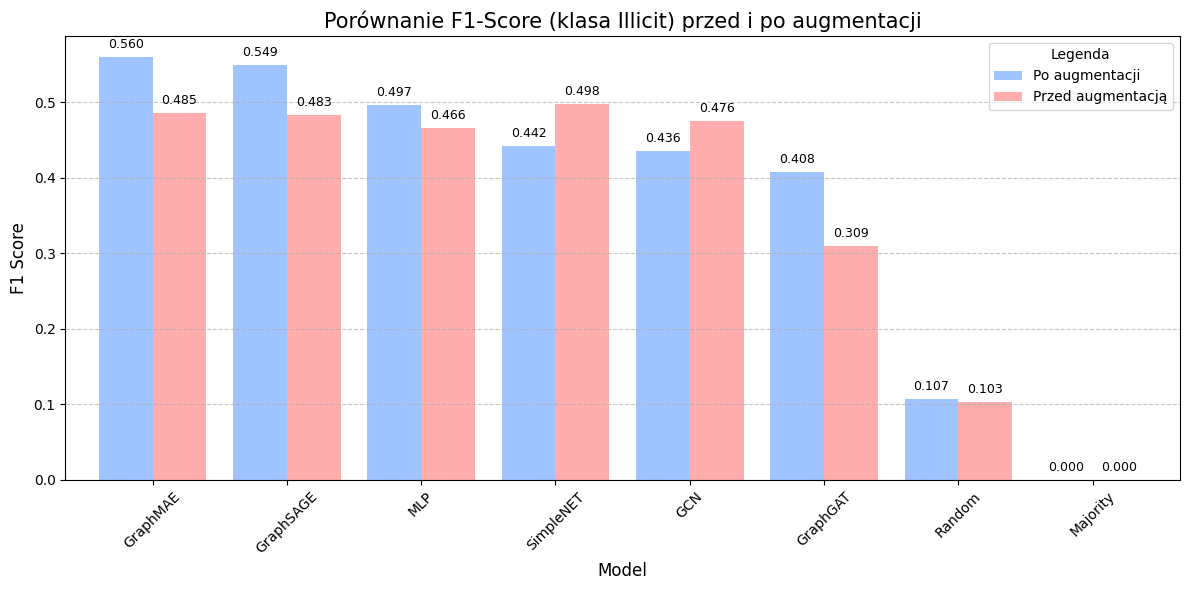

In [13]:
df_before = pd.DataFrame(results_log)
df_after = pd.DataFrame(results_log_aug)

df_before['Status'] = 'Przed augmentacją'
df_after['Status'] = 'Po augmentacji'

df_compare = pd.concat([df_before, df_after])

df_plot = df_compare.pivot(index='Model', columns='Status', values='Illicit F1')

df_plot = df_plot.sort_values(by='Po augmentacji', ascending=False)

ax = df_plot.plot(kind='bar', figsize=(12, 6), color=['#A0C4FF', '#FFADAD'], width=0.8)

plt.title('Porównanie F1-Score (klasa Illicit) przed i po augmentacji', fontsize=15)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Legenda")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=9)

plt.tight_layout()
plt.show()


# Wizualizacja wyników

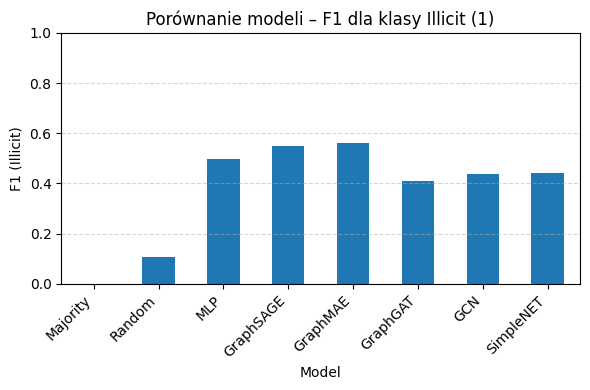

In [14]:
# === Wykres słupkowy F1 dla klasy 1 (Illicit) ===
plt.figure(figsize=(6, 4))
df_results["Illicit F1"].plot(kind="bar")
plt.title("Porównanie modeli – F1 dla klasy Illicit (1)")
plt.ylabel("F1 (Illicit)")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

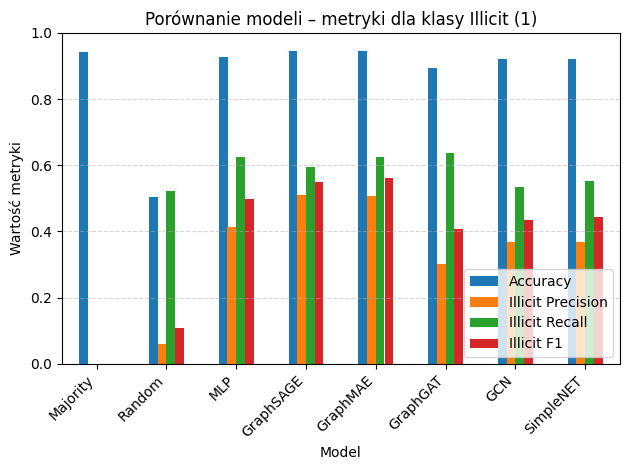

In [15]:
# === Wykres zbiorczy kilku metryk ===
metrics_to_plot = ["Accuracy", "Illicit Precision", "Illicit Recall", "Illicit F1"]

plt.figure(figsize=(8, 5))
df_results[metrics_to_plot].plot(kind="bar")
plt.title("Porównanie modeli – metryki dla klasy Illicit (1)")
plt.ylabel("Wartość metryki")
plt.ylim(0.0, 1.0)

plt.xticks(rotation=45, ha="right")

plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

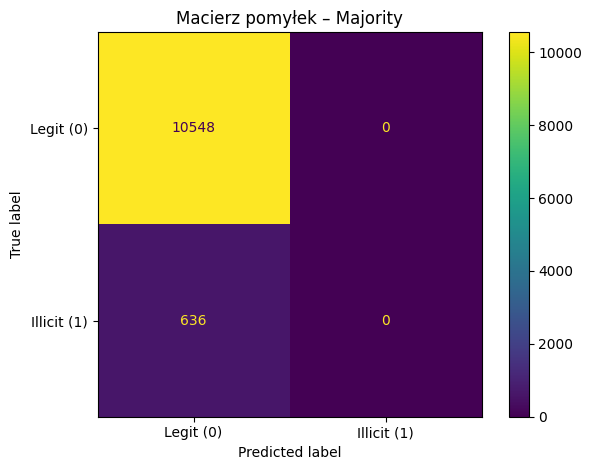

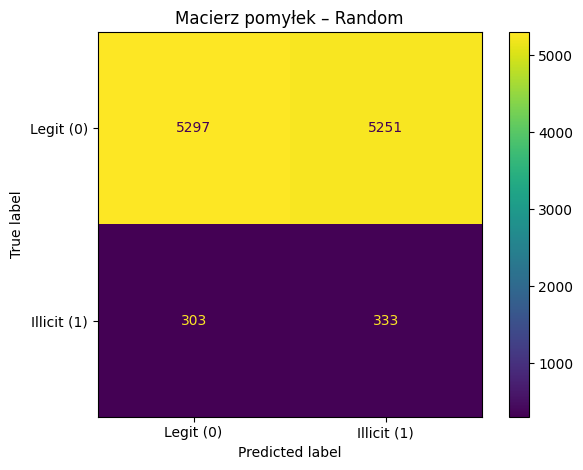

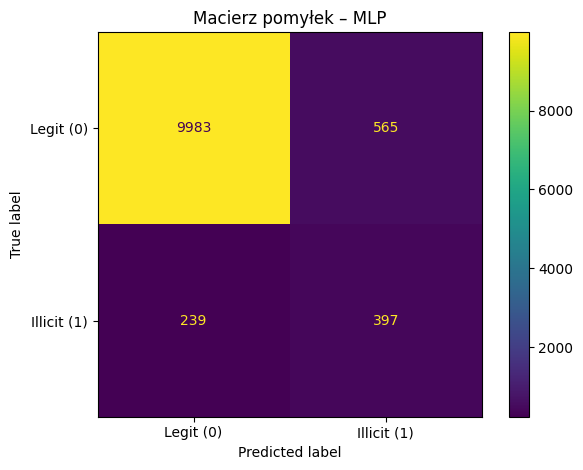

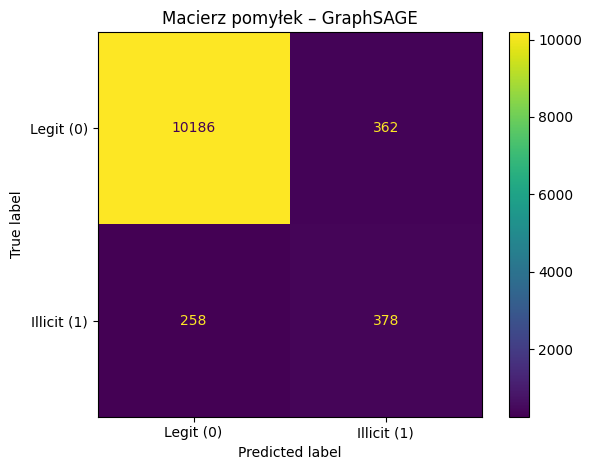

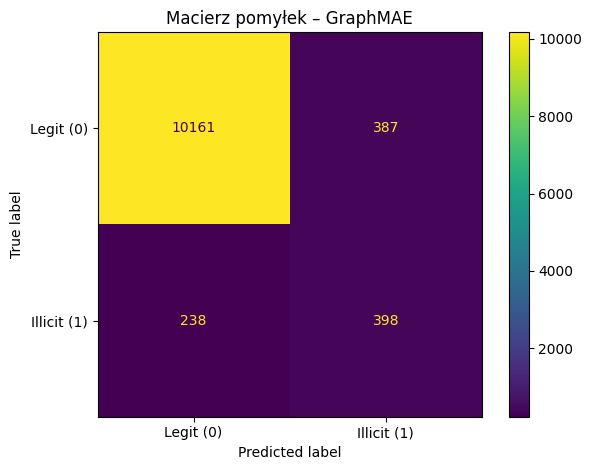

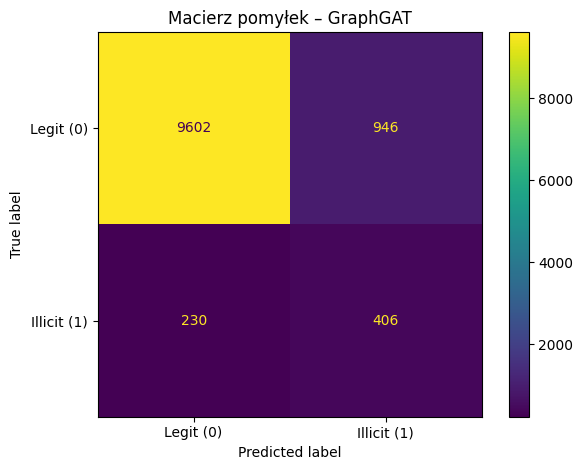

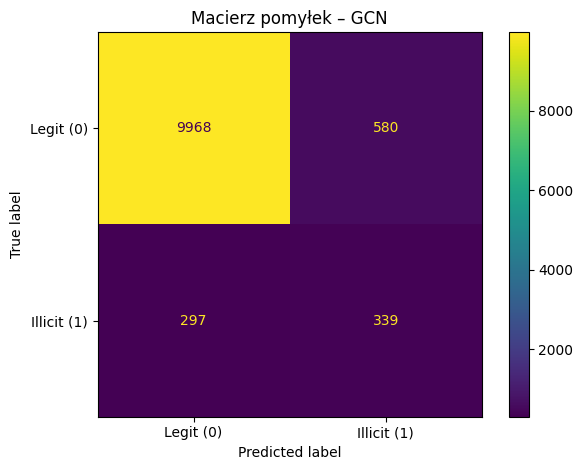

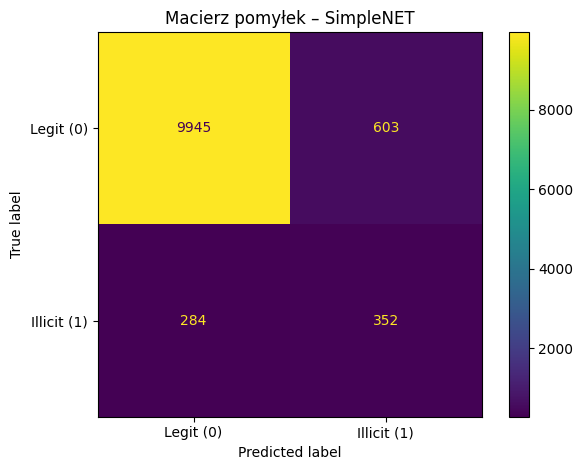

In [16]:
for model_name in df_results.index:
    data = all_preds[model_name]
    y_pred_np = data["y_pred"]

    cm = confusion_matrix(y_test_np, y_pred_np, labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Legit (0)", "Illicit (1)"]
    )
    disp.plot(values_format="d")
    plt.title(f"Macierz pomyłek – {model_name}")
    plt.tight_layout()
    plt.show()

## ROC Curve

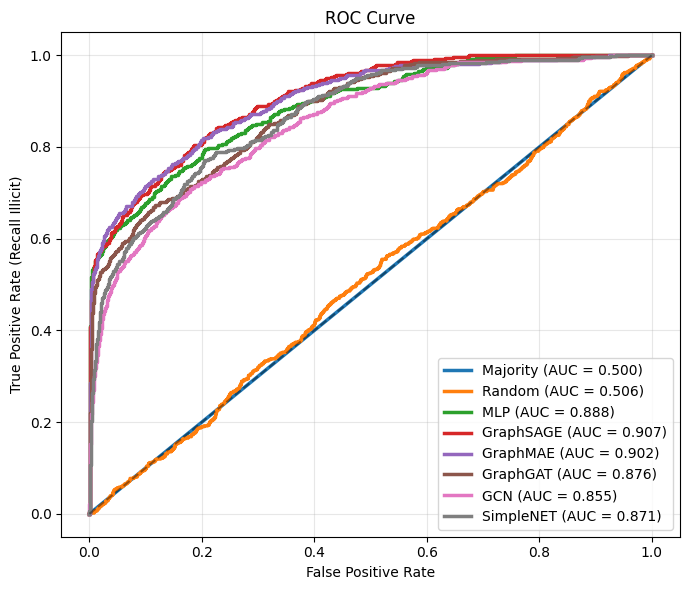

In [17]:
plt.figure(figsize=(7, 6))

for model_name, data in all_preds.items():
    y_score = data["y_score"]   # P(Illicit = 1)

    fpr, tpr, _ = roc_curve(y_test_np, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr, tpr,
        linewidth=2.5,
        label=f"{model_name} (AUC = {roc_auc:.3f})"
    )

# linia losowa
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall Illicit)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()